In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def plotOne(img1, title1, cmap1=None):
    plt.imshow(img1, cmap=cmap1)
    plt.title(title1, fontsize=20)
    plt.show()
    return

def plotMany(nrows, ncols, images, titles, cmaps):
    f, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
    if nrows == 1 or ncols == 1:
        for idx, img in enumerate(images):
            axes[idx].imshow(img, cmap=cmaps[idx])
            axes[idx].set_title(titles[idx], fontsize=20) 
    else:
        c = 0
        for idx, img in enumerate(images):
            r = idx//ncols
            axes[r,c].imshow(img, cmap=cmaps[idx])
            axes[r,c].set_title(titles[idx], fontsize=20)
            c = (idx + 1) % ncols        
    plt.tight_layout()
    plt.show()
    return

def plotTwo(img1, img2, title1, title2, cmap1=None, cmap2=None):
    plotMany(1, 2, [img1,img2], [title1,title2], [cmap1,cmap2])
    return

def plotStacked(img1, img2, combined, title1, title2):
    # Stack each channel to view contributions
    stacked = np.dstack((np.zeros_like(img1), img1, img2))
    plotTwo(stacked, combined, title1, title2, None, 'gray')

In [5]:
def applyThreshold(binary, thresh):
    # Apply the threshold
    binary_th = np.zeros_like(binary)
    binary_th[(binary >= thresh[0]) & (binary <= thresh[1])] = 1
    return binary_th

def applyThresholdSobelAbs(img, orient, sobel_kernel, thresh):
    # Calculate the directional gradient
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return applyThreshold(scaled_sobel, thresh)

def applyThresholdSobelMag(img, sobel_kernel, thresh):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    return applyThreshold(scaled_sobel, thresh)

def applyThresholdSobelDir(img, sobel_kernel, thresh):
    # Calculate gradient direction
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.sqrt(np.square(sobelx))
    abs_sobely = np.sqrt(np.square(sobely))
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    return applyThreshold(dir_sobel, thresh)

def applyAllThresholds(img, kSize, thresh, threshDir):
    gradx = applyThresholdSobelAbs(img, 'x', kSize, thresh)
    grady = applyThresholdSobelAbs(img, 'y', kSize, thresh)
    magB = applyThresholdSobelMag(img, kSize, thresh)
    dirB = applyThresholdSobelDir(img, kSize, threshDir)
    return gradx, grady, magB, dirB 


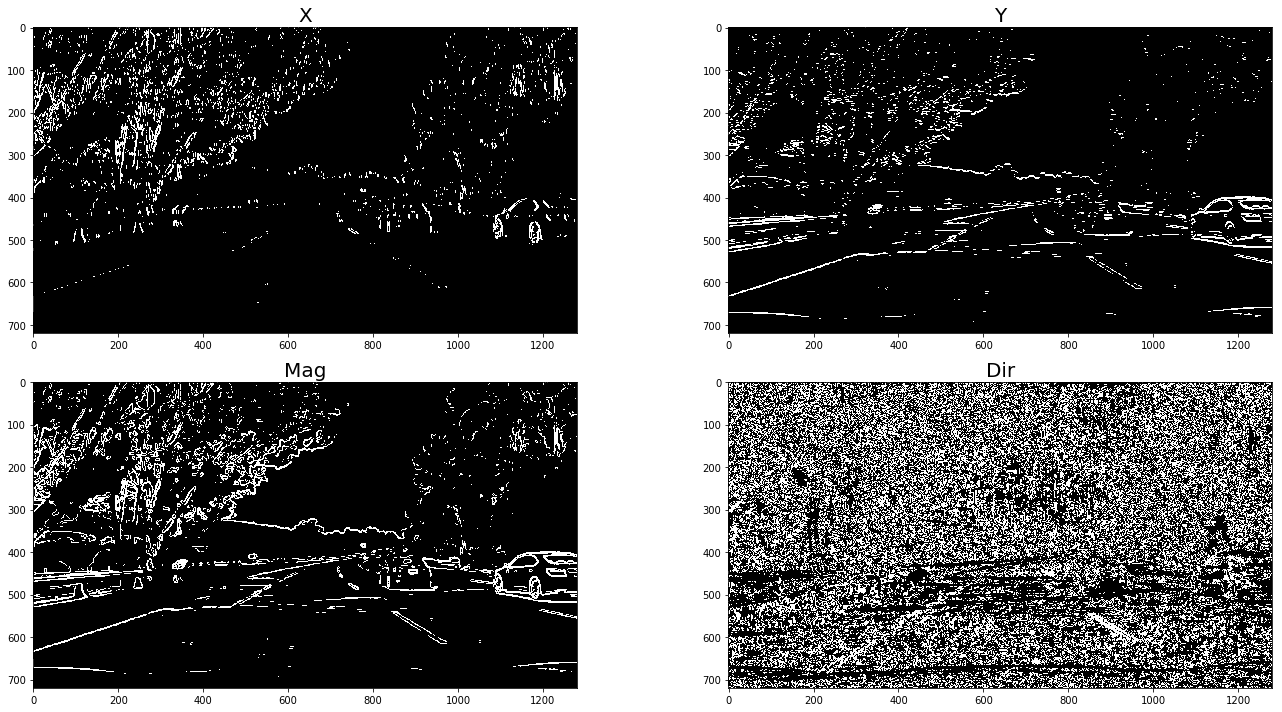

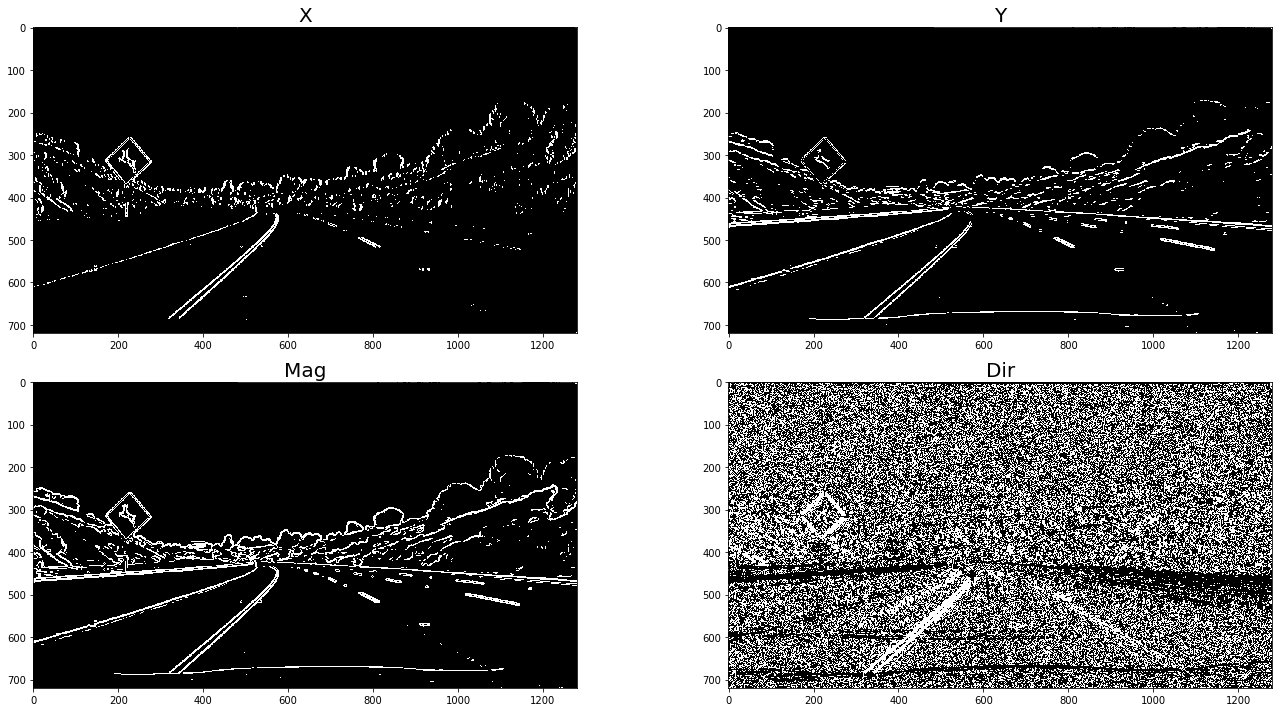

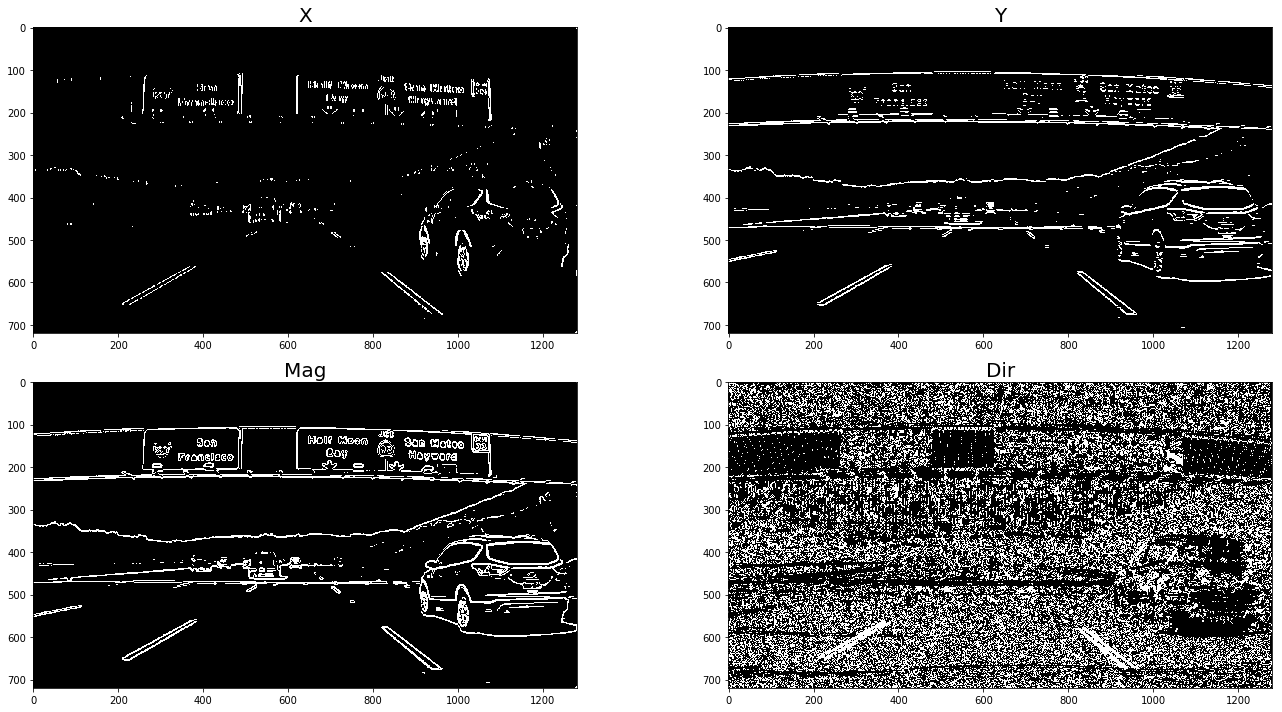

In [6]:
# Read in an image
images = []
images.append(mpimg.imread('test_images/test5.jpg'))
images.append(mpimg.imread('test_images/test2.jpg'))
images.append(mpimg.imread('signs_vehicles_xygrad.jpg'))

kSize = 9
thresh = (50,255)
threshDir = (0.5, 1.2)

for img in images:
    gradx, grady, magB, dirB, = applyAllThresholds(img, kSize, thresh, threshDir)
    plotMany(2, 2, [gradx,grady,magB,dirB], ['X','Y','Mag','Dir'], ['gray','gray','gray','gray'])

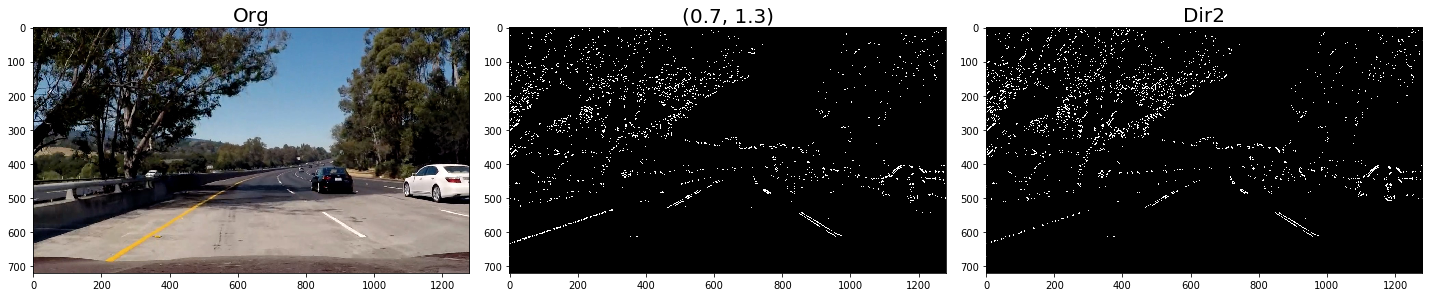

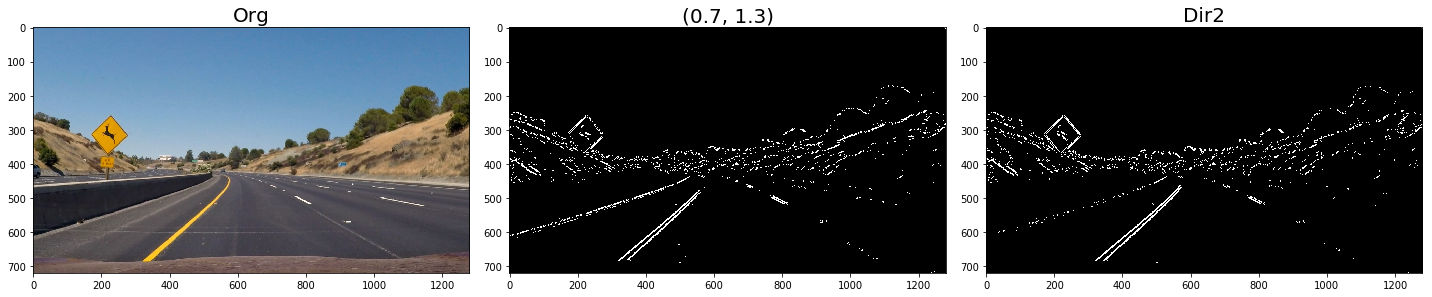

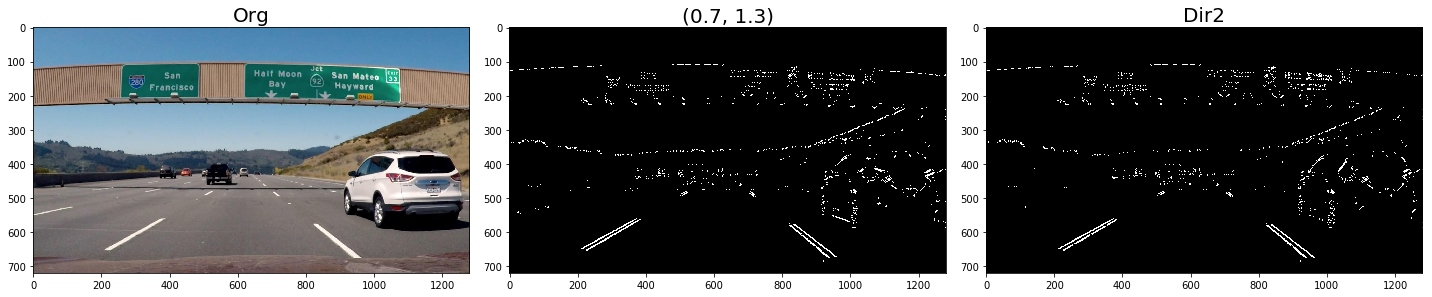

In [7]:
for img in images:
    gradx, grady, magB, dirB1 = applyAllThresholds(img, kSize, thresh, (0.7,1.3))   
    c1 = np.zeros_like(dirB1)
    c1[((magB == 1) & (dirB1 == 1))] = 1
    
    dirB2 = applyThresholdSobelDir(img, kSize, (0.5, 1.2))
    c2 = np.zeros_like(dirB2)
    c2[((magB == 1) & (dirB2 == 1))] = 1
    
    plotMany(1, 3, [img, c1, c2], ['Org','(0.7, 1.3)', 'Dir2'], [None, 'gray','gray'])

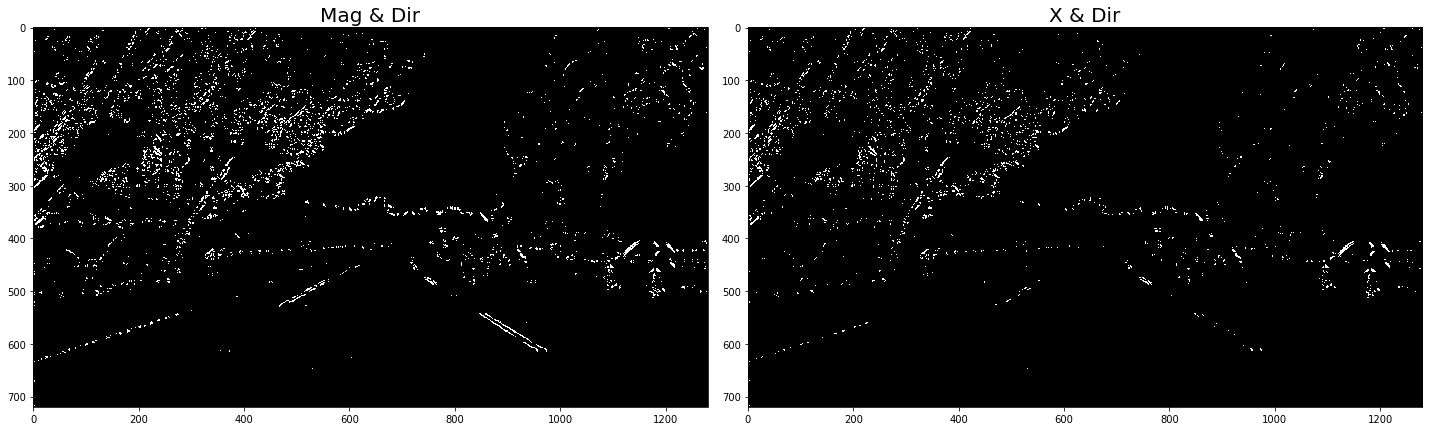

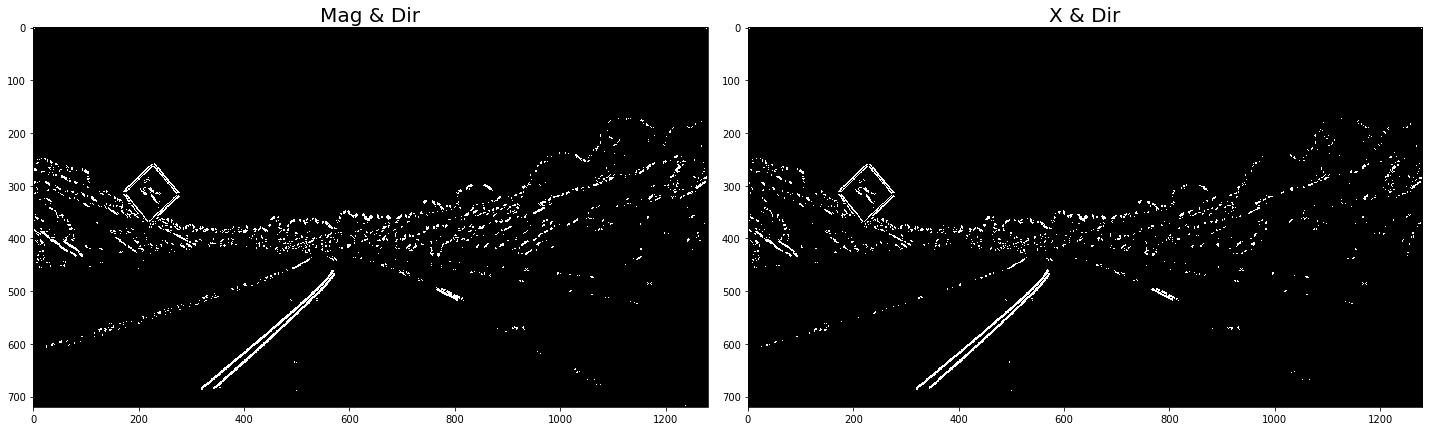

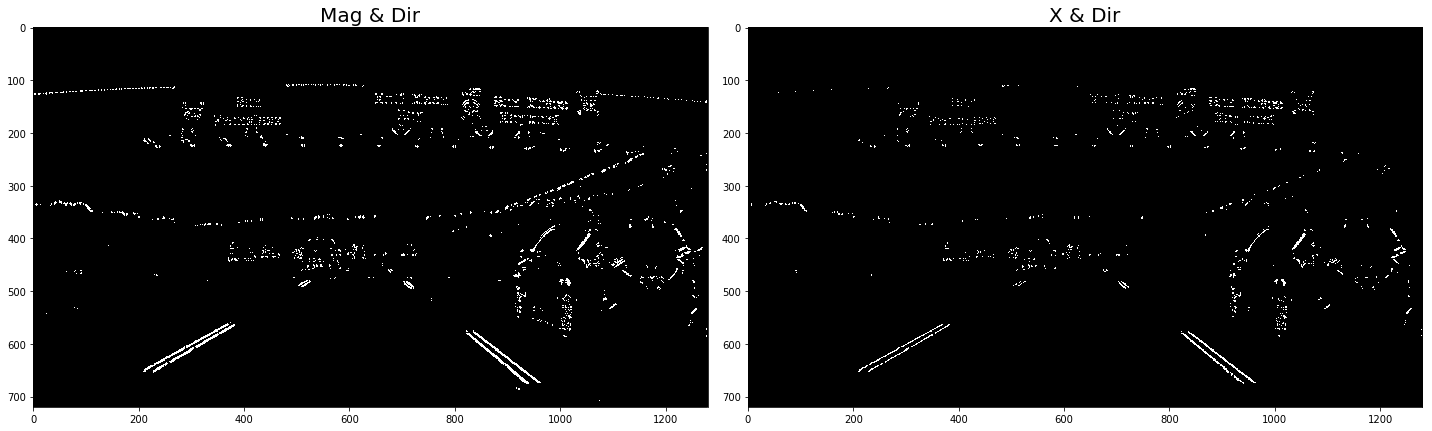

In [49]:
for img in images:
    gradx, grady, magB, dirB = applyAllThresholds(img, kSize, thresh, threshDir)
    
    c1 = np.zeros_like(dirB)
    c1[((gradx == 1)&(grady == 1))|((magB == 1)&(dirB == 1))] = 1
    
    c2 = np.zeros_like(dirB)
    c2[((magB == 1) & (dirB == 1))] = 1
    
    c3 = np.zeros_like(dirB)
    c3[((gradx == 1) & (dirB == 1))] = 1
    
    plotMany(1, 2, [c2, c3], ['Mag & Dir', 'X & Dir'], ['gray','gray'])

In [19]:
def plotColorChannels(img, colorspace, titles):
    converted = cv2.cvtColor(img, colorspace).astype(np.float)
    channel1 = converted[:,:,0]
    channel2 = converted[:,:,1]
    channel3 = converted[:,:,2]
    plotMany(2, 2, [img, channel1, channel2, channel3], titles, [None,None,None,None])

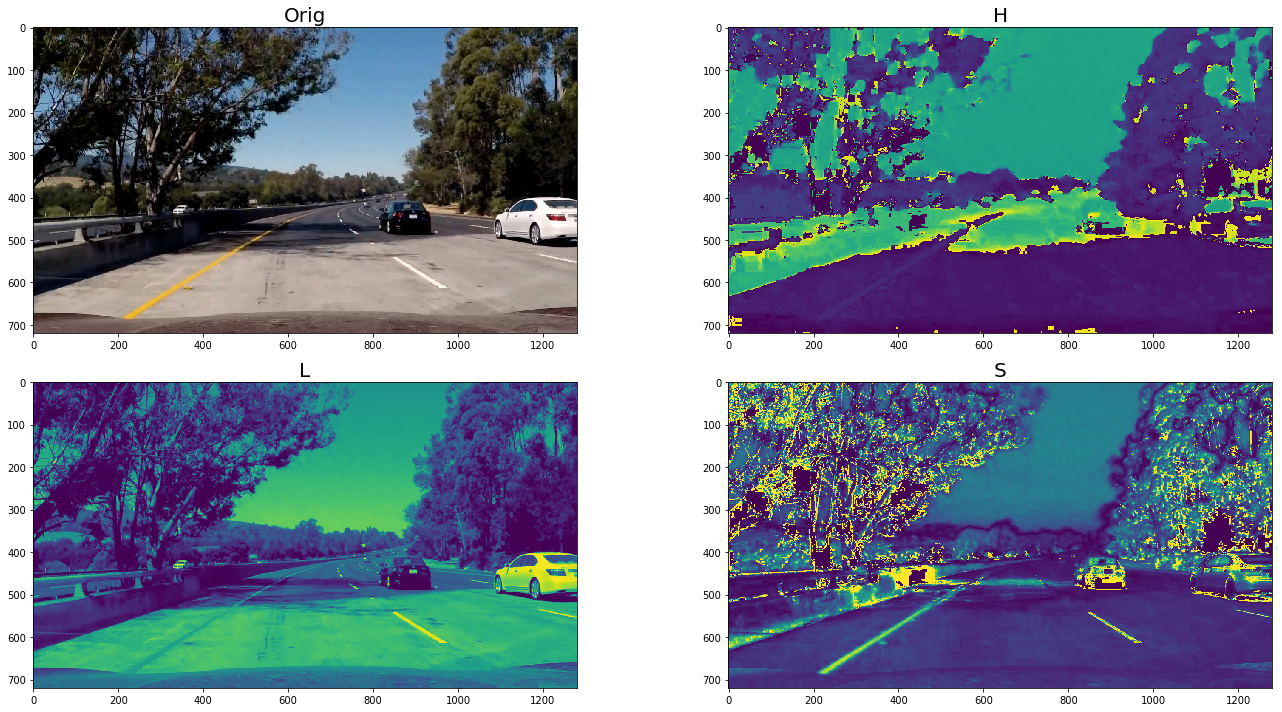

In [20]:
img = images[0]
plotColorChannels(img, cv2.COLOR_RGB2HLS, ['Orig', 'H', 'L', 'S'])

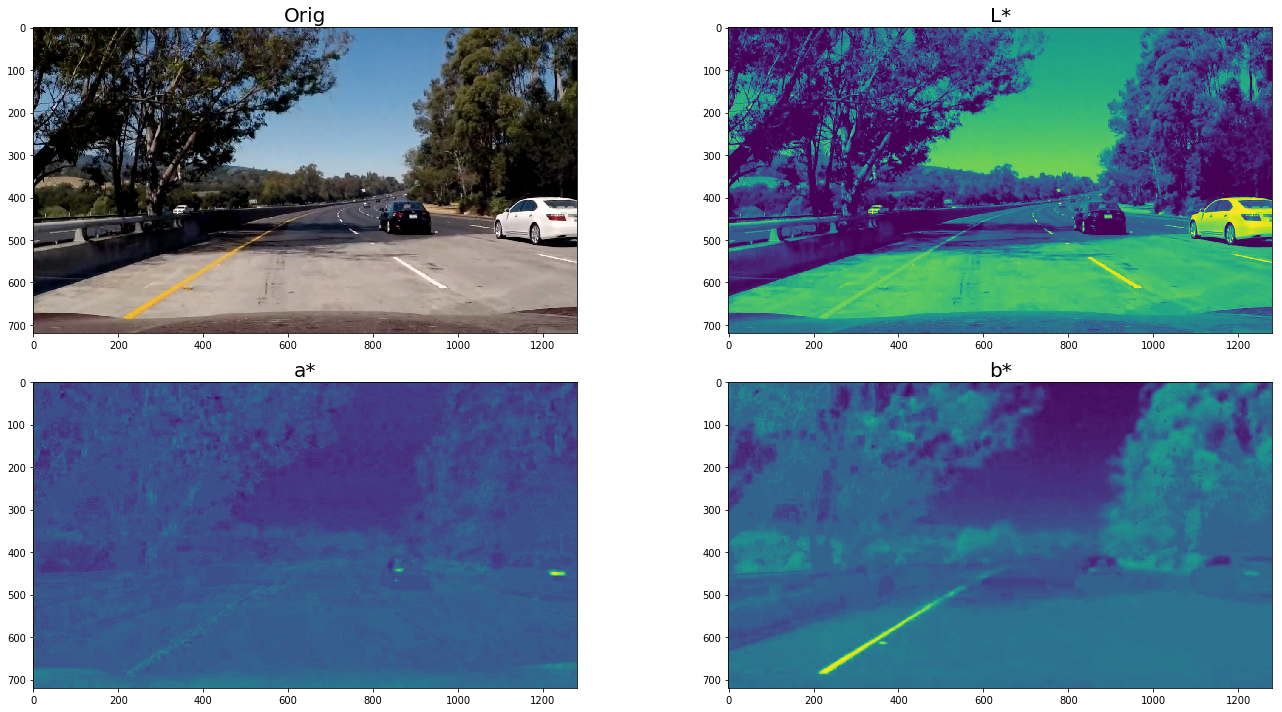

In [27]:
plotColorChannels(img, cv2.COLOR_RGB2Lab, ['Orig', 'L*', 'a*', 'b*'])

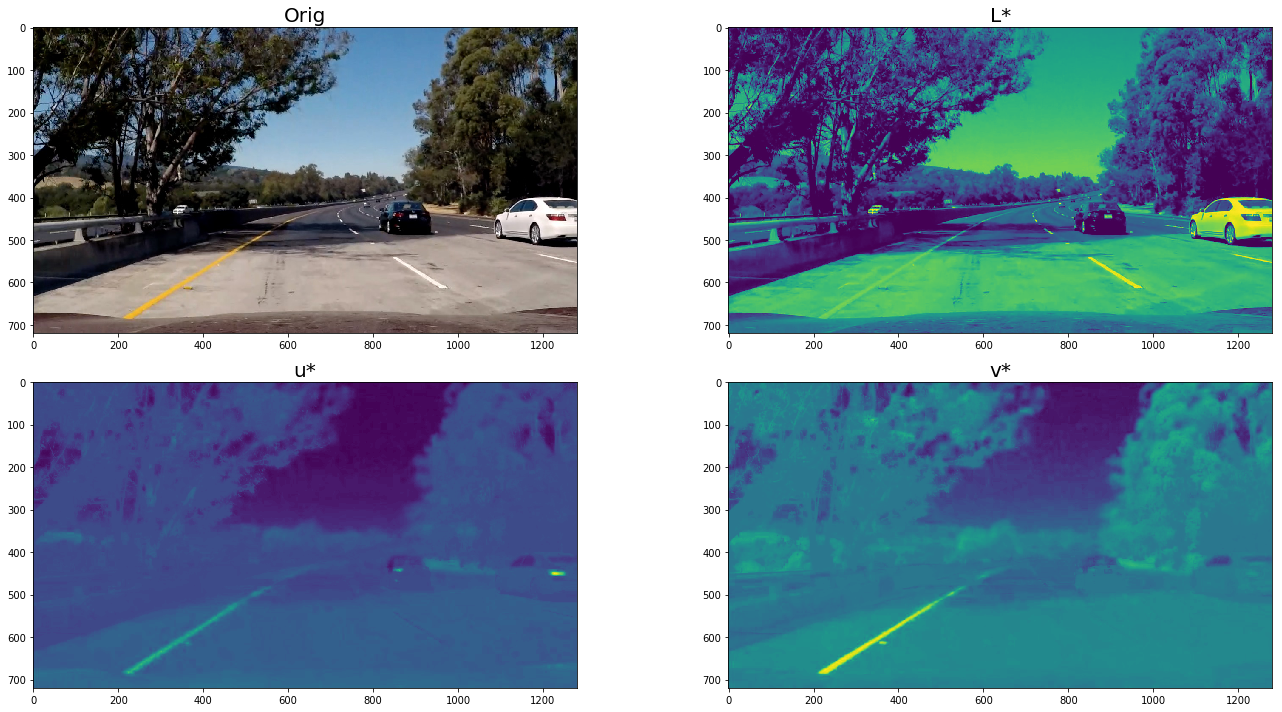

In [21]:
plotColorChannels(img, cv2.COLOR_RGB2Luv, ['Orig', 'L*', 'u*', 'v*'])

In [62]:
def applyThresholdSaturation(img, thresh):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    return applyThreshold(s_channel, thresh)

def applyThresholdYellow(img,thresh):
    # Convert to CIELAB color space and use the b channel
    # which ranges from blues to yellows
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab).astype(np.float)
    b_channel = lab[:,:,2]
    return applyThreshold(b_channel, thresh)

def applyThresholdWhite(img,thresh):
    # Convert to CIELAB color space and use the L channel
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab).astype(np.float)
    l_channel = lab[:,:,0]
    return applyThreshold(l_channel, thresh)        

def applyThresholdColors(img):
    # Convert to CIELAB color space and use the L channel for whites
    # and the b channel (blues to yellows) for yellows
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab).astype(np.float)
    l_channel = lab[:,:,0]
    lB = applyThreshold(l_channel, (210,255))
    b_channel = lab[:,:,2]
    bB = applyThreshold(b_channel, (150,255))
    combo = np.zeros_like(lB)
    combo[((lB == 1)|(bB == 1))] = 1
    return combo

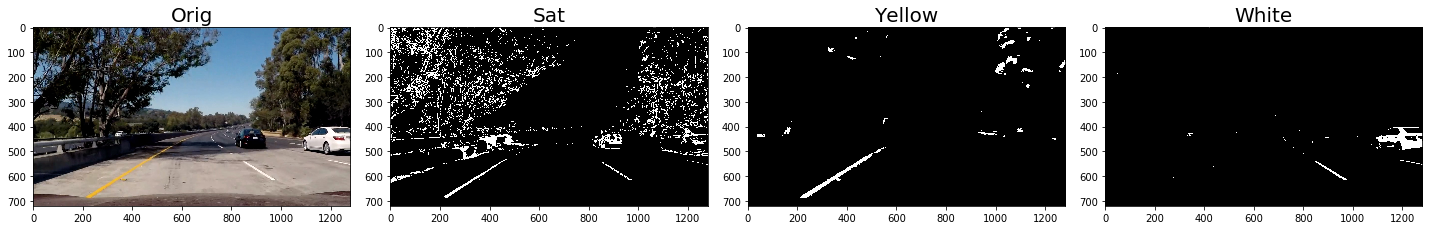

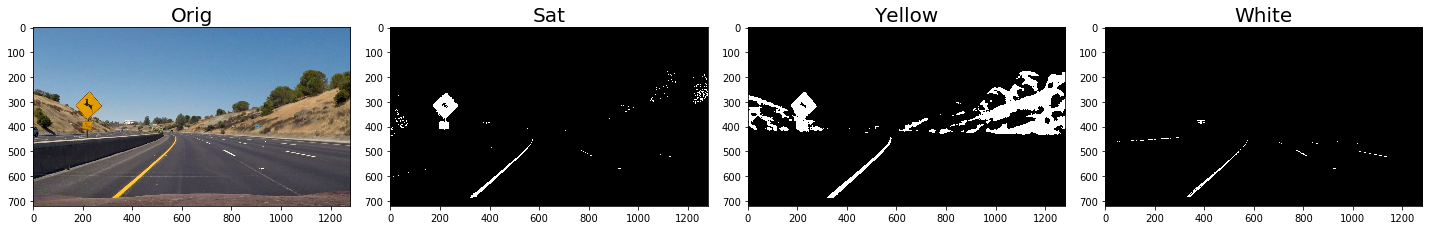

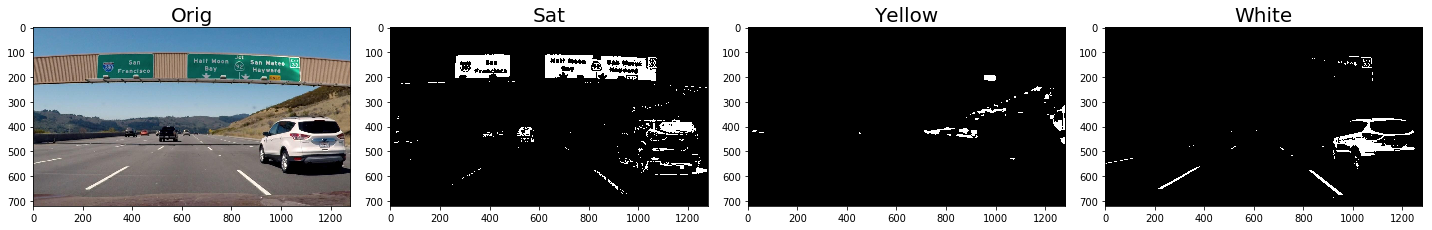

In [63]:
threshS = (170,255)
threshY = (150,255)
threshW = (210,255)

for img in images:
    satB = applyThresholdSaturation(img, threshS)
    yellowB = applyThresholdYellow(img, threshY)
    whiteB = applyThresholdWhite(img, threshW)
    plotMany(1,4, [img, satB, yellowB, whiteB], ['Orig', 'Sat','Yellow', 'White'], [None,'gray','gray','gray'])

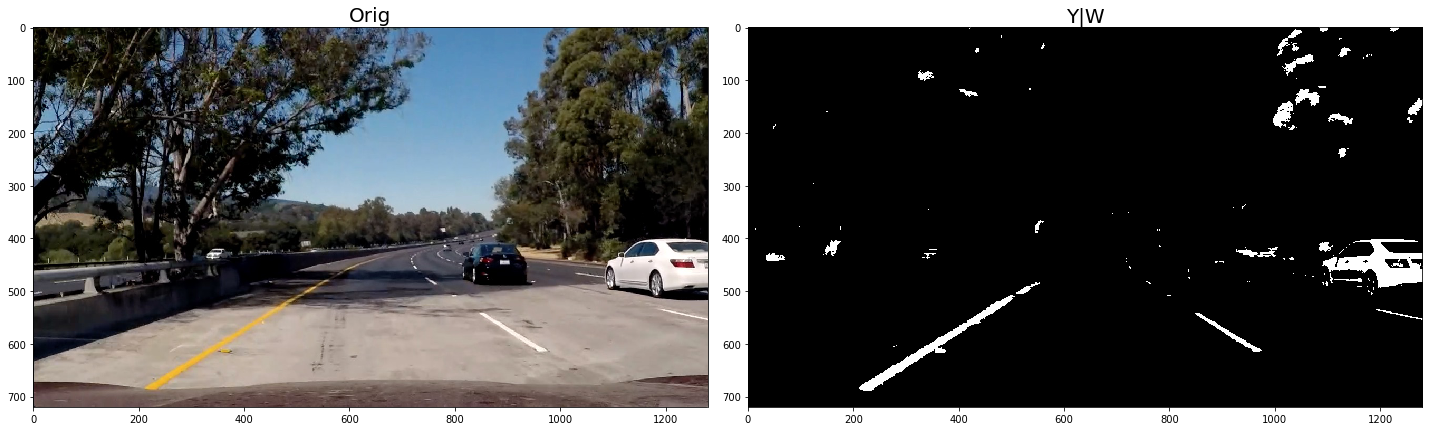

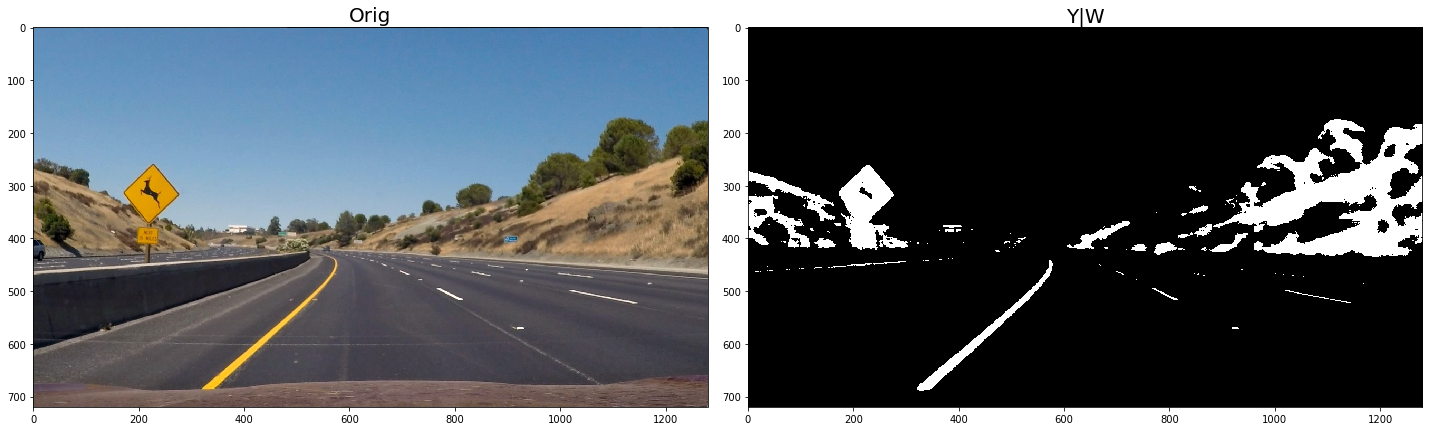

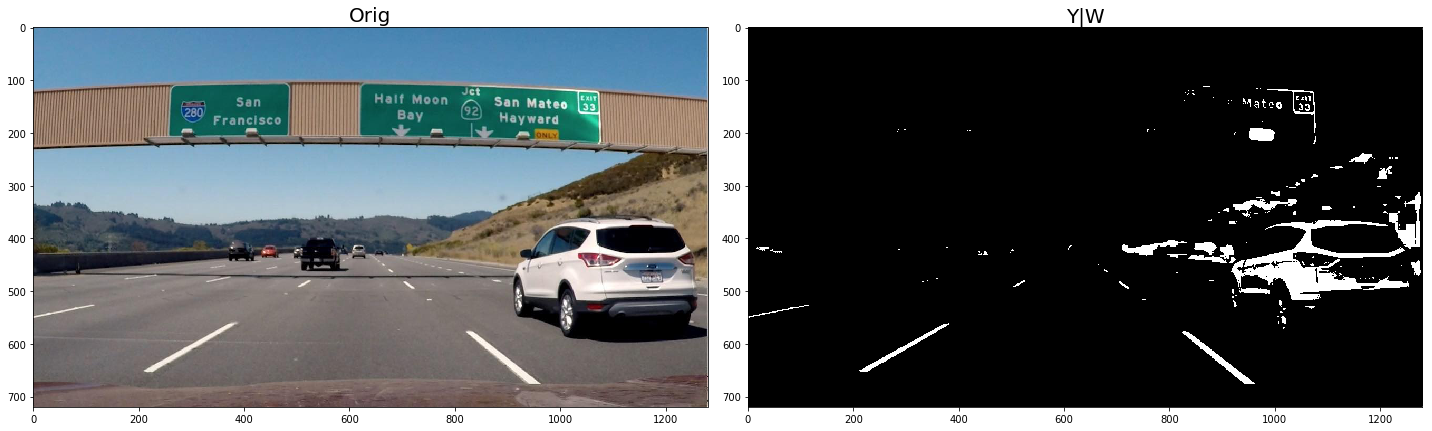

In [64]:
for img in images:
    combo = applyThresholdColors(img)
    plotTwo(img, combo, 'Orig', 'Y|W', None,'gray')
    

In [74]:
def combineWithColors(binary, title):
    cColors = applyThresholdColors(img)
    combo = np.zeros_like(binary)
    combo[(cColors == 1)|(binary == 1)] = 1 
    plotStacked(binary, cColors, combo, title, 'Combo')

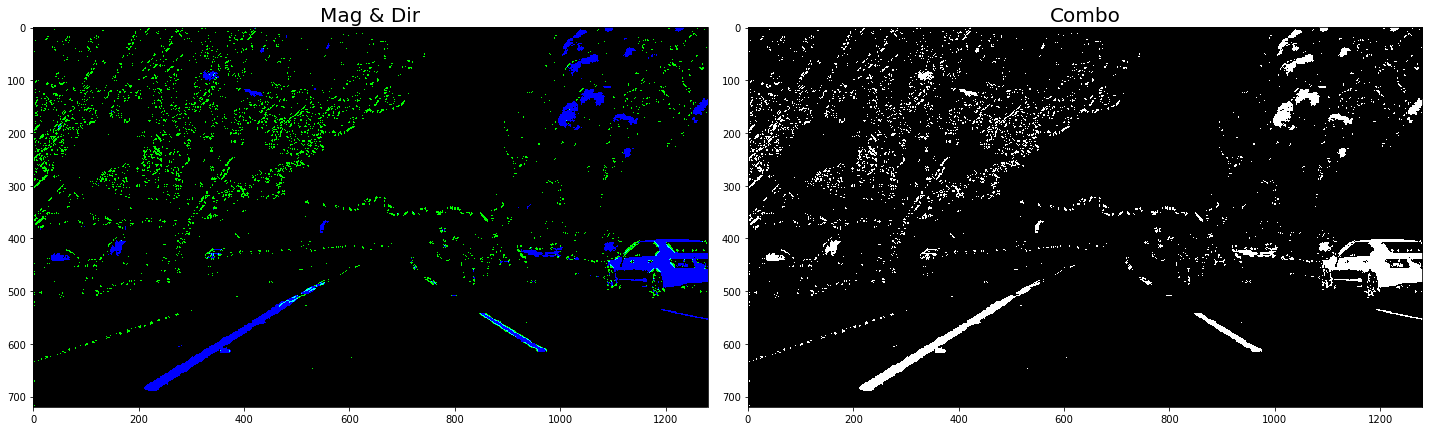

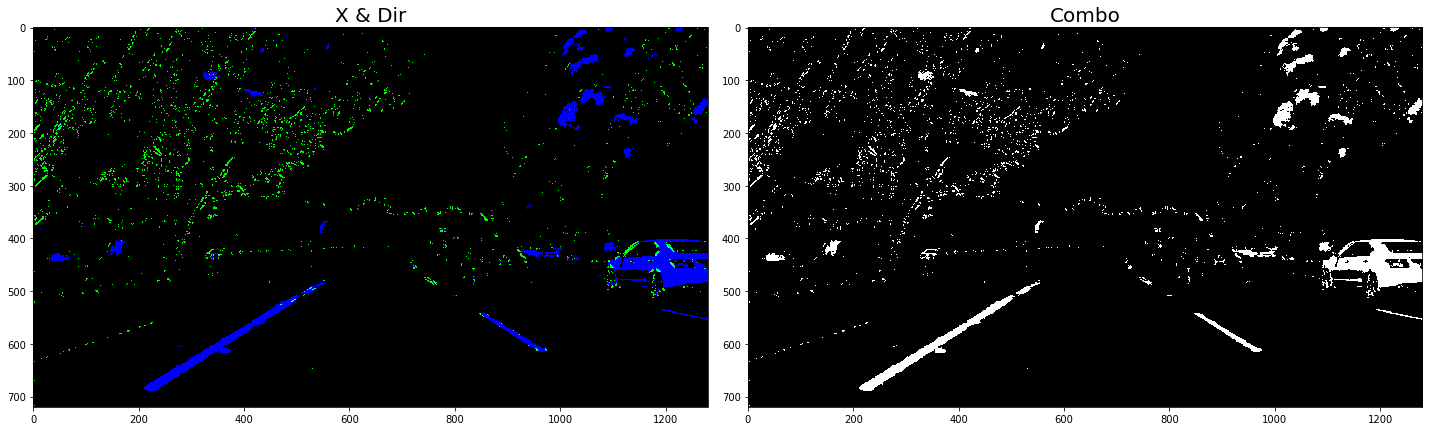

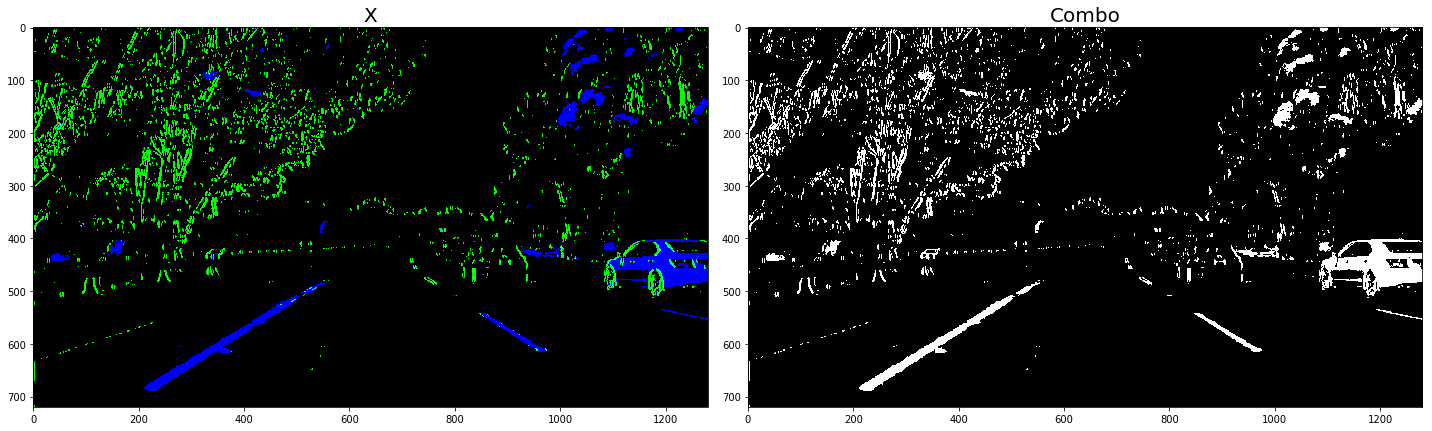

In [75]:
img = images[0]
gradx, grady, magB, dirB = applyAllThresholds(img, kSize, thresh, threshDir)

opt = np.zeros_like(dirB)
opt[((magB == 1) & (dirB == 1))] = 1
combineWithColors(opt, 'Mag & Dir')

opt = np.zeros_like(dirB)
opt[((gradx == 1) & (dirB == 1))] = 1
combineWithColors(opt, 'X & Dir')

combineWithColors((gradx == 1), 'X')